# 车流越线计数-视频预测-简单场景

同济子豪兄 2023-5-21

## 导入工具包

In [1]:
import time
from tqdm import tqdm

import cv2
import numpy as np

from ultralytics import YOLO

import supervision as sv
from supervision.draw.color import Color

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 载入目标检测模型

In [2]:
# model = YOLO('yolov8n.pt')
model = YOLO('yolov8x.pt')

## 可视化配置

In [3]:
# 越线检测位置
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3790, 1500)
line_counter = sv.LineZone(start=LINE_START, end=LINE_END)

# 线的可视化配置
line_color = Color(r=224, g=57, b=151)
line_annotator = sv.LineZoneAnnotator(thickness=6, text_thickness=3, text_scale=3, color=line_color)

In [4]:
# 目标检测可视化配置
box_annotator = sv.BoxAnnotator(
    thickness=3,
    text_thickness=2,
    text_scale=1.5
)

## 载入视频

In [5]:
# 车流越线计数-简单场景
input_path ='videos/line_count_1.mp4'

## 准备视频处理

In [6]:
filehead = input_path.split('/')[-1]
output_path = "out-" + filehead

# 获取视频总帧数
cap = cv2.VideoCapture(input_path)
frame_count = 0
while(cap.isOpened()):
    success, frame = cap.read()
    frame_count += 1
    if not success:
        break
cap.release()
print('视频总帧数为',frame_count)

cap = cv2.VideoCapture(input_path)
frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))

视频总帧数为 539


## 视频逐帧追踪

In [7]:
with tqdm(total=frame_count-1) as pbar:
    
    for result in model.track(source=input_path, show=False, stream=True, verbose=False, device='cuda:0'):

        frame = result.orig_img

        # 用 supervision 解析预测结果
        detections = sv.Detections.from_yolov8(result)

        ## 过滤掉某些类别
        # detections = detections[(detections.class_id != 60) & (detections.class_id != 0)]

        # 解析追踪ID
        detections.tracker_id = result.boxes.id.cpu().numpy().astype(int)

        # 获取每个目标的：追踪ID、类别名称、置信度
        class_ids = detections.class_id     # 类别ID
        confidences = detections.confidence # 置信度
        tracker_ids = detections.tracker_id # 多目标追踪ID
        labels = ['#{} {} {:.1f}'.format(tracker_ids[i], model.names[class_ids[i]], confidences[i]*100) for i in range(len(class_ids))]
        
        # 绘制目标检测可视化结果
        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        
        # 越线检测
        
        line_counter.trigger(detections=detections)
        
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        out.write(frame)

        pbar.update(1)
        
cv2.destroyAllWindows()
out.release()
cap.release()
print('视频已保存', output_path)

print('共跨线进入 ', line_counter.in_count)
print('共跨线离开 ', line_counter.out_count)

100%|██████████| 538/538 [01:56<00:00,  4.62it/s]

视频已保存 out-line_count_1.mp4
共跨线进入  2
共跨线离开  7


## 展示视频最后一帧画面

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

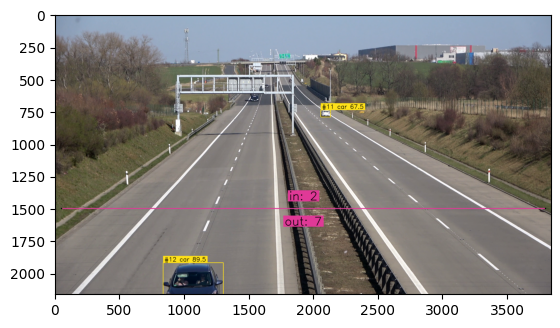

In [9]:
plt.imshow(frame[:,:,::-1])
plt.show()